In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from bnn import MnistBNN

import matplotlib.pyplot as plt

tfd = tfp.distributions

data_dir = "/scratch/gf332/Misc/datasets/"

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
mnist = tfds.load("mnist", data_dir=data_dir)

In [4]:
model_save_dir = "/scratch/gf332/Misc/bnn_experiments/bnn/adaptive_sghmc"

In [5]:
model = MnistBNN(prior_mode="per_unit")
model.build(input_shape=(1, 28, 28, 1))

ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)#.expect_partial()
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from /scratch/gf332/Misc/bnn_experiments/bnn/adaptive_sghmc/ckpt-109


tf.Tensor(
[[10.207422   -3.947017    1.4677496  -3.600501   -1.3905262  -0.43768513
   0.3148603  -6.696678    1.5976071  -1.1196823 ]], shape=(1, 10), dtype=float32)
Actual:  0
Prediction: 0


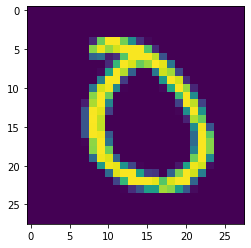

In [6]:
test_ds = mnist['test']
test_ds = test_ds.map(lambda x: (tf.cast(x["image"], tf.float32) / 255., x["label"])).shuffle(300)

for im, label in test_ds.batch(1).take(1):
    
    plt.imshow(im[0, ..., 0])
    
    probs = model(im)
    
    print(probs)
    
    print("Actual: ", label[0].numpy())
    print("Prediction:", tf.argmax(probs, axis=1)[0].numpy())

In [7]:
test_accuracy = 0.
total_size = 0.

batch_size = 500

for im, label in test_ds.batch(batch_size).take(1):
    
    probs = model(im)
    
    test_accuracy += tf.reduce_sum(tf.cast(tf.argmax(probs, axis=1) == label, tf.float32))
    
    total_size += tf.cast(label.shape[0], tf.float32)
    
test_accuracy = test_accuracy / total_size

In [8]:
test_accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.974>

In [12]:
model.transforms[1].bias

<tf.Variable 'gaussian_dense_with_gamma_prior/bias:0' shape=(100,) dtype=float32, numpy=
array([-0.29713684,  0.32107168, -1.0266901 ,  0.17350578, -0.5020012 ,
       -0.59763753, -0.00177804, -0.24735036,  0.11382482, -0.8367385 ,
        0.20227253,  0.27358875,  0.5031383 , -0.37280738, -0.2405046 ,
        0.23428324,  0.27635968, -0.07192654, -0.7104178 , -0.34404817,
       -0.16803259, -0.7808662 , -0.01223843, -0.3145847 ,  0.35771242,
        0.2958176 ,  0.23228861,  0.25939608, -0.12189829, -0.0613293 ,
       -0.14819543,  0.2223088 ,  0.24345465, -0.5299225 ,  1.5751497 ,
        0.42177474,  0.11472531, -0.13012785, -0.5817252 , -0.01348955,
        0.79825485, -0.1720647 , -0.1810886 , -0.20753472,  0.19347312,
       -0.28785712,  0.13102017, -0.14525807,  1.2507814 , -0.98688066,
       -0.24045835,  0.04439099, -0.90586984,  0.19602628,  0.5625319 ,
       -0.13005766, -0.47572732, -0.32455593, -0.23806043,  0.18258114,
        0.33942118, -0.02304162,  0.04944873, -